Stages:

A. Fetch and process data

B. Define initial model

C-1. Tuning hyperparameters 1

D-1. Selecting features 1

C-2. Tuning hyperparameters 2

E. Training final model and saving output

A. Fetch and process data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression
from sklearn.compose import TransformedTargetRegressor
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV

from  helper_functions_training import *

In [2]:
#load training data
raw_train_df = pd.read_csv('train_house_final.csv')

#Numerically encode categorical features
train_df_encode = encode_categories(raw_train_df)

#Split train dataset into X (features) and y (targets)
X_train_all = train_df_encode.drop('Price', axis=1)
y_train_all = train_df_encode['Price']

#Split train data into train and validate subsets
df_train, df_validate = train_test_split(train_df_encode, random_state=89)

#split train and validate subsets into X and y
X_train = df_train.drop('Price', axis=1)
y_train = df_train['Price']
X_validate = df_validate.drop('Price', axis=1)
y_validate = df_validate['Price']

X_train_all.shape, y_train_all.shape, X_train.shape, y_train.shape, X_validate.shape, y_validate.shape

((2832894, 19), (2832894,), (2124670, 19), (2124670,), (708224, 19), (708224,))

B. Define initial model

In [3]:
#Defining pipeline for linear model

#Pipeline for X
X_pipeline = Pipeline([('log_transform', LogTransformer()),
                       ('scaler', StandardScaler()),
                       ('regressor', LinearRegression())])
#Pipeline including log of y
linear_model_pipeline = TransformedTargetRegressor(regressor = X_pipeline,
                                             transformer = ConditionalLogTransformer())

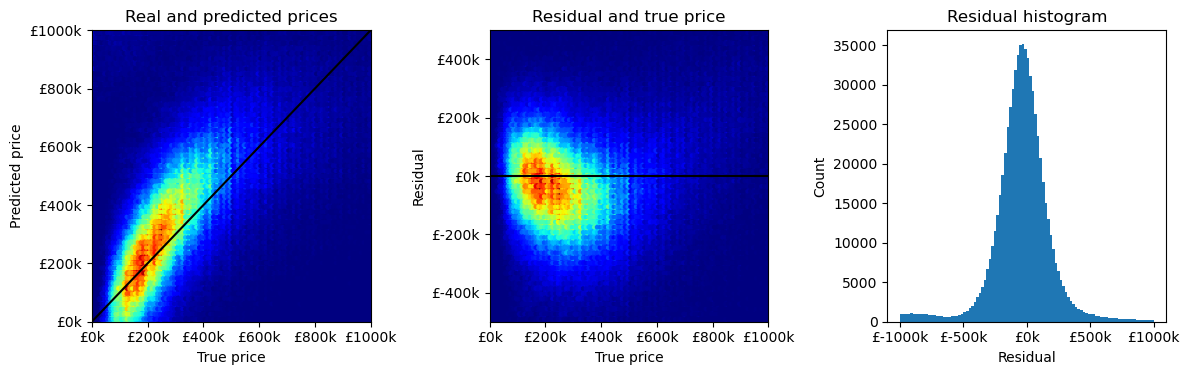

R² = 0.055


In [4]:
#Initial model fit
model_1 = clone(linear_model_pipeline)
model_1.fit(X_train,y_train)
y_validate_predict = model_1.predict(X_validate)
assess_predict(y_validate, y_validate_predict)

C-1. Tuning hyperparameters 1

In [5]:
param_grid_1 = {'regressor__log_transform__log_income': [True, False],
              'regressor__log_transform__log_listings': [True, False],
              'transformer__log_target': [True, False]}

# Grid search
grid_search = GridSearchCV(
    model_1,
    param_grid_1,
    cv=3,
    return_train_score=True,
    scoring='r2')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                             LogTransformer()),
                                                                            ('scaler',
                                                                             StandardScaler()),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=ConditionalLogTransformer()),
             param_grid={'regressor__log_transform__log_income': [True, False],
                         'regressor__log_transform__log_listings': [True,
                                                                    False],
                         'transformer__log_target': [True, False]},
             return_train_score=True, scoring='r2')

In [6]:
print("Best parameters:", grid_search.best_params_)
#Best fit is when no log transformation of features or targets. Hyperparameters not updated from the default, so new new model saved

Best parameters: {'regressor__log_transform__log_income': False, 'regressor__log_transform__log_listings': False, 'transformer__log_target': False}


D-1. Selecting features 1

In [7]:
features_to_include = X_train.columns.values
feature_importance = feature_importance_test(model_1, X_train, y_train, X_validate, y_validate)

r2 = 0.055, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'Eng_Wal' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: Eng_Wal

r2 = 0.054, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'sine_day' 'cosine_day' 'Type_D'
 'Type_F' 'Type_S' 'Type_T']
least important feature: sine_day

r2 = 0.054, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'gender_ratio' 'child_ratio'
 'elderly_ratio' 'commute_distance' 'Income' 'London_distance'
 'listings_per_capita' 'days_since_first' 'cosine_day' 'Type_D' 'Type_F'
 'Type_S' 'Type_T']
least important feature: cosine_day

r2 = 0.054, change = 0.000
features: ['New' 'Tenure' 'latitude' 'longitude' 'ge

In [8]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
feature_importance
#Features determined to have significant effect on R2:
#'child_ratio' 'commute_distance' 'Income' 'London_distance' 'Type_D' 'Type_F' 'Type_S' 'Type_T'

,least_important_feature,r2,r2_change
0,Eng_Wal,0.055,0.000
1,sine_day,0.054,0.000
2,cosine_day,0.054,0.000
3,latitude,0.054,0.000
4,days_since_first,0.054,0.000
5,New,0.054,0.000
6,listings_per_capita,0.054,0.000
7,gender_ratio,0.054,0.000
8,longitude,0.054,0.000
9,Tenure,0.054,0.000


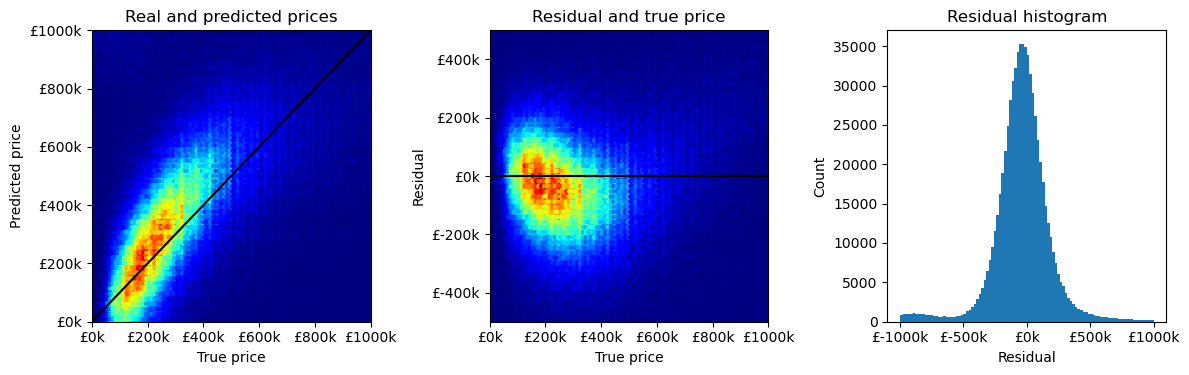

R² = 0.054


In [9]:
features_to_include_2 = [
    'child_ratio',
    'commute_distance',
    'Income',
    'London_distance',
    'Type_D',
    'Type_F',
    'Type_S',
    'Type_T'
]

#New model with updated features
model_2 = clone(linear_model_pipeline)
model_2.set_params()

#Train and assess model
model_2.fit(X_train[features_to_include_2],y_train)
y_validate_predict = model_2.predict(X_validate[features_to_include_2])
assess_predict(y_validate, y_validate_predict)

C-2. Tuning hyperparameters 2

In [10]:
param_grid_2 = {'regressor__log_transform__log_income': [True, False],
              'regressor__log_transform__log_listings': [True, False],
              'transformer__log_target': [True, False]}

# Grid search
grid_search = GridSearchCV(
    model_2,
    param_grid_2,
    cv=3,
    return_train_score=True,
    scoring='r2')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('log_transform',
                                                                             LogTransformer()),
                                                                            ('scaler',
                                                                             StandardScaler()),
                                                                            ('regressor',
                                                                             LinearRegression())]),
                                                  transformer=ConditionalLogTransformer()),
             param_grid={'regressor__log_transform__log_income': [True, False],
                         'regressor__log_transform__log_listings': [True,
                                                                    False],
                         'transformer__log_target': [True, False]},
             return_train_score=True, scoring='r2')

In [11]:
print("Best parameters:", grid_search.best_params_)
#Hyperparameters unchanged from previous iteration
#Convergence reached

Best parameters: {'regressor__log_transform__log_income': False, 'regressor__log_transform__log_listings': False, 'transformer__log_target': False}


E. Training final model and saving output


In [6]:
#Prepare final model

#Optimised hyperparameters
linear_model_final = clone(linear_model_pipeline).set_params()

#Optimised features
important_feautures_final = [
    'child_ratio',
    'commute_distance',
    'Income',
    'London_distance',
    'Type_D',
    'Type_F',
    'Type_S',
    'Type_T'
]

linear_model_final.fit(X_train_all[important_feautures_final], y_train_all)

,"regressor regressor: object, default=NoneRegressor object such as derived from:class:`~sklearn.base.RegressorMixin`. This regressor willautomatically be cloned each time prior to fitting. If `regressor isNone`, :class:`~sklearn.linear_model.LinearRegression` is created and used.",Pipeline(step...egression())])
,"transformer transformer: object, default=NoneEstimator object such as derived from:class:`~sklearn.base.TransformerMixin`. Cannot be set at the same timeas `func` and `inverse_func`. If `transformer is None` as well as`func` and `inverse_func`, the transformer will be an identitytransformer. Note that the transformer will be cloned during fitting.Also, the transformer is restricting `y` to be a numpy array.",ConditionalLogTransformer()
,"func func: function, default=NoneFunction to apply to `y` before passing to :meth:`fit`. Cannot be setat the same time as `transformer`. If `func is None`, the function used will bethe identity function. If `func` is set, `inverse_func` also needs to beprovided. The function needs to return a 2-dimensional array.",None
,"inverse_func inverse_func: function, default=NoneFunction to apply to the prediction of the regressor. Cannot be set atthe same time as `transformer`. The inverse function is used to returnpredictions to the same space of the original training labels. If`inverse_func` is set, `func` also needs to be provided. The inversefunction needs to return a 2-dimensional array.",None
,"check_inverse check_inverse: bool, default=TrueWhether to check that `transform` followed by `inverse_transform`or `func` followed by `inverse_func` leads to the original targets.",True
,log_income,False
,log_listings,False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True


In [10]:
#Fetch test data
raw_test_df = pd.read_csv('test_house_final.csv')

#Numerically encode categorical features
test_df_encode = encode_categories(raw_test_df)

#Split train dataset into X (features) and y (targets)
X_test = test_df_encode.drop('Price', axis=1)
y_test = test_df_encode['Price']

X_test.shape, y_test.shape

((523267, 19), (523267,))

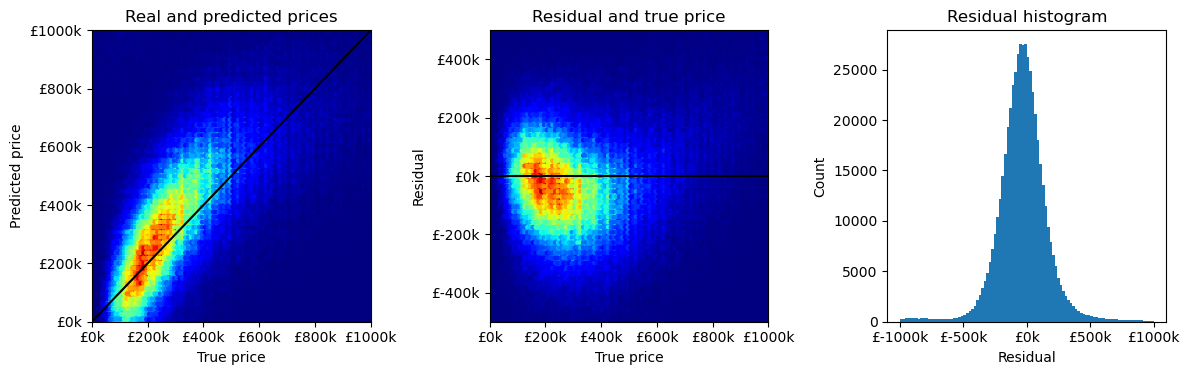

R² = 0.030


In [13]:
#Predict prices of test data
y_test_pred_final = linear_model_final.predict(X_test[important_feautures_final])

#Check fit
assess_predict(y_test, y_test_pred_final)

In [20]:
#Save final fit to csv
final_fit = pd.DataFrame({
    'True_Price': y_test,
    'Linear_Prediction': y_test_pred_final
})
final_fit.to_csv('test_results\\linear_model.csv', index_label='Index', float_format='%.2f')